## Spot Analysis of BF Correction

Originally written by Alex Broughton



In [9]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_14/conda/envs/lsst-scipipe-3.0.0-ext/eups 	setup
lsst_distrib          g4eaec17cb9+23bdaa02ee 	w_latest w_2022_14 current setup


In [10]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from lsst.obs.lsst import LsstCam
from lsst.afw.cameraGeom.utils import findAmp
from lsst.geom import Point2I
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
import logging


logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [11]:
import sys
sys.path.append('/sdf/home/a/abrought/bin')
from SpotAnalysis import Analyzer, readData, getSensorData

#### Read Data

In [12]:
outdir = "/sdf/home/a/abrought/run5/BF/data/"
data = readData( outdir + "data_13230_R02_S00_2022-04-21T03:12:25_corrected.pkl", \
                 outdir + "data_13231_R02_S00_2022-04-21T04:08:43_corrected.pkl", \
                 expstoremove=1)


File 1
12.0s, 16 images
14.0s, 20 images
16.0s, 20 images
18.0s, 20 images
20.0s, 20 images
22.0s, 20 images
24.0s, 20 images
26.0s, 20 images
28.0s, 20 images
30.0s, 20 images
32.0s, 20 images
34.0s, 20 images
36.0s, 20 images
38.0s, 20 images
40.0s, 20 images


File 2
1.25s, 18 images
2.5s, 26 images
3.75s, 39 images
5.0s, 40 images
6.25s, 40 images
7.5s, 40 images
8.75s, 40 images
10.0s, 40 images
11.25s, 40 images
12.5s, 40 images


Combined
1.25s, 18 images
2.5s, 26 images
3.75s, 39 images
5.0s, 40 images
6.25s, 40 images
7.5s, 40 images
8.75s, 40 images
10.0s, 40 images
11.25s, 40 images
12.0s, 16 images
12.5s, 40 images
14.0s, 20 images
16.0s, 20 images
18.0s, 20 images
20.0s, 20 images
22.0s, 20 images
24.0s, 20 images
26.0s, 20 images
28.0s, 20 images
30.0s, 20 images
32.0s, 20 images
34.0s, 20 images
36.0s, 20 images
38.0s, 20 images
40.0s, 20 images


Text(0.5, 0, 'MJD')

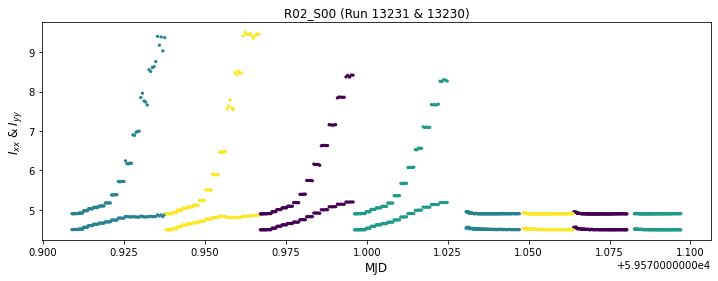

In [13]:
xx = []
yy = []
mjd = []
exptime = []
botx = []
boty = []
size = []

for t in data:
    xx.append(np.nanmedian(t['base_SdssShape_xx']))
    yy.append(np.nanmedian(t['base_SdssShape_yy']))
    size.append(len(t['base_SdssCentroid_x']))
    mjd.append(t['MJD'])
    botx.append(t['BOTX'])
    boty.append(t['BOTY'])
    exptime.append(t['exptime'])

plt.figure(figsize=(12,4), facecolor='white')
plt.title("R02_S00 (Run 13231 & 13230)", fontsize=12)
sca = plt.scatter(mjd, xx, c=np.array(botx)/np.array(boty), s=5)
sca = plt.scatter(mjd, yy, c=np.array(botx)/np.array(boty), s=5)
#plt.scatter(mjd, yy, c=np.asarray(botx)/np.asarray(boty), s=5)
#plt.xlim(0.900,1.100)
#plt.ylim(4.9,5.5)
#plt.colorbar(sca, label="BOT pos (unitless)")
plt.ylabel(r'$I_{xx}\;&\;I_{yy}$', rotation=90, fontsize=12, loc='center')
plt.xlabel("MJD", fontsize=12)

## Main Plot

In [6]:
ptc_turnoffs, cti_turnoffs, mos, gains, gains_linearized, other_gains = getSensorData(sensor="R02_S00", detector=9)

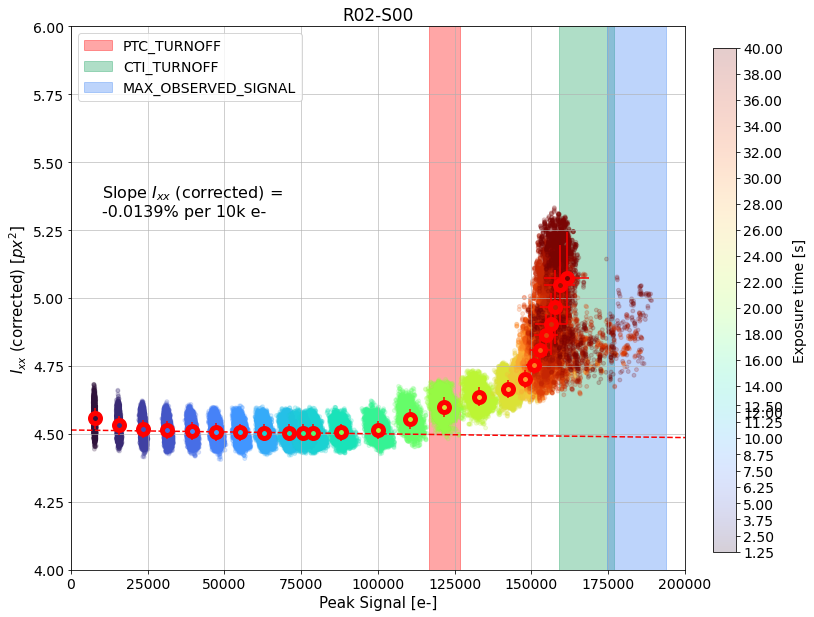

In [14]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
datale = data
exptimes = np.unique(data['exptime'])
#ref = data_corr[np.where(data_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="peakSignal"
#xkey = "base_PsfFlux_instFlux"
#xkey="base_CircularApertureFlux_25_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"

fontsize=14
T0s = []

# Find all spots common to all images
from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in datale))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
amps = []
for iterable in datale:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]

    x.extend(iterable[xkey])
    Y1=iterable[y1key]
    Y2=iterable[y2key]
    amps.extend(iterable["amps"])
    y.extend( Y1 )
    IxxErrs.extend(iterable["base_SdssShape_xxErr"])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"])
    ixx.extend(iterable["base_SdssShape_xx"])
    iyy.extend(iterable["base_SdssShape_yy"])
    
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
e = np.array(e)
amps = np.array(amps)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())

n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(11,10), facecolor='w')
ax = plt.subplot(111)

# Plot the min and max ptc turnoffs for this sensor
ax.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.35, color='red', label = "PTC_TURNOFF")
ax.axvspan(np.min(cti_turnoffs), np.max(cti_turnoffs), alpha=0.35, color='#1aa260', label = "CTI_TURNOFF")
ax.axvspan(np.min(mos), np.max(mos), alpha=0.35, color='#4285F4', label = "MAX_OBSERVED_SIGNAL")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_lowestexp = []
errofstderr_lowestexp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

fitx = []
fity = []

for j, i in enumerate(exptimes):
    
    import matplotlib
    normalize = matplotlib.colors.Normalize(vmin=1.25, vmax=40)

    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],c=e[cond], cmap='turbo', norm=normalize, s=15, alpha=0.2)
    
    num = len(x[cond])
    from astropy.stats import bootstrap
    #errofstderr_lowestexp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.mean(i)   
    aggregated.x = np.mean(x[cond])
    aggregated.y = np.mean(y[cond])
    aggregated.xerr = np.std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))

    
    stderrs_lowestexp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    if i <= 12. and i > 6:
        fitx.append(aggregated.x)
        fity.append(aggregated.y)
        
    for spec in [1]:
        sca3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

    


ax.set_ylabel("{}".format("$I_{xx}$ (corrected) $[px^{2}]$"),fontsize=15)
ax.set_xlabel("Peak Signal [e-]", fontsize=15, y=-10)
ax.set_xlim(0,200000)
#ax.set_ylim(4.5,6.0)
ax.set_ylim(4.,6.0)
#ax.set_ylim(.05,.45)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rcParams.update({'font.size': fontsize})

ax.grid(alpha=0.75)
m, b  = np.polyfit(fitx, fity, 1)
slope = m*100*1000
plt.text(10000.,5.30,"{}".format(r"Slope $I_{xx}$ (corrected) = ") + "\n" + str(round(slope,4)) +"% per 10k e-", fontsize=16)

ax.plot(np.linspace(0,5.5e6, 1000), m*np.linspace(0,5.5e6, 1000) + b, color="red" , linestyle="--")
x1 = np.linspace(0,5.5e6, 1000)
y1 = m*np.linspace(0,5.5e6, 1000) + b



#for ch in [90595.07, 118279.234] :
#        ax.axvline(ch, c="k", ls="-", alpha=0.75, label="Low/High Max obs. signal")
plt.legend(loc=2)
        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.935, 0.15, 0.03, 0.7])
cb = plt.colorbar(sca,cax=cbar_ax, ticks=[1.25,2.5,3.75,5.0,6.25,7.5,8.75,10.0,11.25,12.0,12.5,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0])


sca.set_clim(1.25,40)
cb.set_label("Exposure time [s]", labelpad=10)
plt.subplots_adjust(right=0.90,hspace=0)
ax.set_title("R02-S00")
plt.savefig("../plots/Ixx-corrected-R02_S00.png", bbox_inches='tight')

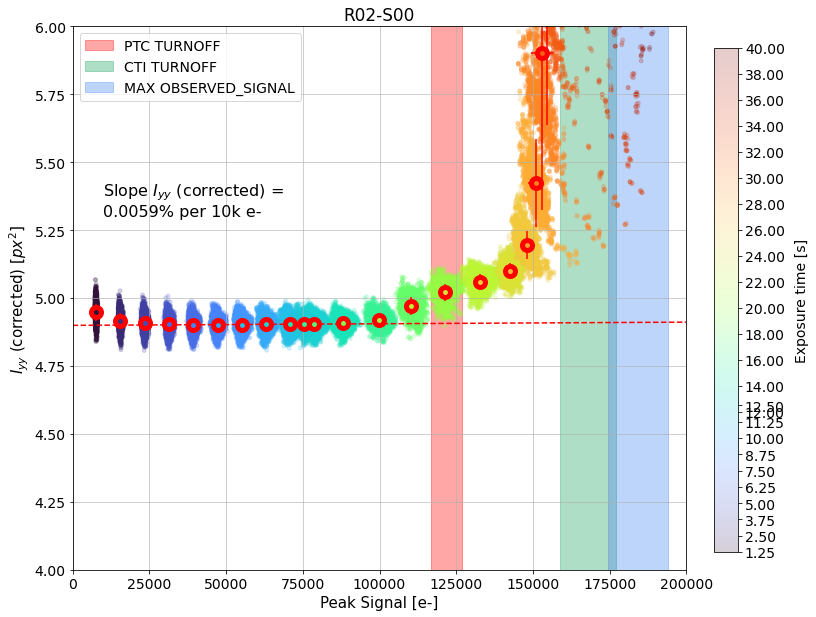

In [15]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
datale = data
exptimes = np.unique(data['exptime'])
#ref = data_corr[np.where(data_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_yy"
y2key="base_SdssShape_yy"
xkey="peakSignal"
#xkey = "base_PsfFlux_instFlux"
#xkey="base_CircularApertureFlux_25_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"

fontsize=14
T0s = []

# Find all spots common to all images
from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in datale))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
amps = []
for iterable in datale:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]

    x.extend(iterable[xkey])
    Y1=iterable[y1key]
    Y2=iterable[y2key]
    amps.extend(iterable["amps"])
    y.extend( Y1 )
    IxxErrs.extend(iterable["base_SdssShape_xxErr"])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"])
    ixx.extend(iterable["base_SdssShape_xx"])
    iyy.extend(iterable["base_SdssShape_yy"])
    
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
e = np.array(e)
amps = np.array(amps)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())

n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(11,10), facecolor='w')
ax = plt.subplot(111)

# Plot the min and max ptc turnoffs for this sensor
ax.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.35, color='red', label = "PTC TURNOFF")
ax.axvspan(np.min(cti_turnoffs), np.max(cti_turnoffs), alpha=0.35, color='#1aa260', label = "CTI TURNOFF")
ax.axvspan(np.min(mos), np.max(mos), alpha=0.35, color='#4285F4', label = "MAX OBSERVED_SIGNAL")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_lowestexp = []
errofstderr_lowestexp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

fitx = []
fity = []

for j, i in enumerate(exptimes):
    
    import matplotlib
    normalize = matplotlib.colors.Normalize(vmin=1.25, vmax=40)

    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],c=e[cond], cmap='turbo', norm=normalize, s=15, alpha=0.2)
    
    num = len(x[cond])
    from astropy.stats import bootstrap
    #errofstderr_lowestexp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.mean(i)   
    aggregated.x = np.mean(x[cond])
    aggregated.y = np.mean(y[cond])
    aggregated.xerr = np.std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))

    
    stderrs_lowestexp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    if i <= 12. and i > 6:
        fitx.append(aggregated.x)
        fity.append(aggregated.y)
        
    for spec in [1]:
        sca3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

    


ax.set_ylabel("{}".format("$I_{yy}$ (corrected) $[px^{2}]$"),fontsize=15)
ax.set_xlabel("Peak Signal [e-]", fontsize=15, y=-10)
ax.set_xlim(0,200000)
#ax.set_ylim(4.5,6.0)
ax.set_ylim(4.,6.0)
#ax.set_ylim(.05,.45)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rcParams.update({'font.size': fontsize})

ax.grid(alpha=0.75)
m, b  = np.polyfit(fitx, fity, 1)
slope = m*100*1000
plt.text(10000.,5.30,"{}".format(r"Slope $I_{yy}$ (corrected) = ") + "\n" + str(round(slope,4)) +"% per 10k e-", fontsize=16)

ax.plot(np.linspace(0,5.5e6, 1000), m*np.linspace(0,5.5e6, 1000) + b, color="red" , linestyle="--")
x1 = np.linspace(0,5.5e6, 1000)
y1 = m*np.linspace(0,5.5e6, 1000) + b



#for ch in [90595.07, 118279.234] :
#        ax.axvline(ch, c="k", ls="-", alpha=0.75, label="Low/High Max obs. signal")
plt.legend(loc=2)
        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.935, 0.15, 0.03, 0.7])
cb = plt.colorbar(sca,cax=cbar_ax, ticks=[1.25,2.5,3.75,5.0,6.25,7.5,8.75,10.0,11.25,12.0,12.5,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0])


sca.set_clim(1.25,40)
cb.set_label("Exposure time [s]", labelpad=10)
plt.subplots_adjust(right=0.90,hspace=0)
ax.set_title("R02-S00")
plt.savefig("../plots/Iyy-corrected-R02_S00.png", bbox_inches='tight')